# Demonstrating methylize regression and plotting

In [1]:
import numpy as np
import pandas as pd
import math
import time
import methylprep
import methylcheck

In [2]:
%load_ext autoreload
%autoreload 2
from methylize import diff_meth_pos, volcano_plot, manhattan_plot

In [3]:
#Install joblib module for parallelization
import sys
!conda install --yes --prefix {sys.prefix} joblib

Solving environment: done

# All requested packages already installed.



In [4]:
# load a processed dataset and the phenotype list per sample.
# in CLI I ran `python -m methylprep process -d GSE69852_copy --betas --m_value to make these files.
betas = pd.read_pickle('../methylize/data/GSE69852_beta_values.pkl')
m_values = pd.read_pickle('../methylize/data/GSE69852_m_values.pkl')
betas.head()
#m_values.head()

,9247377093_R02C01,9247377093_R03C01,9247377093_R06C02,9247377085_R04C02,9247377093_R05C01,9247377093_R02C02
IlmnID,,,,,,
cg00035864,0.236234,0.287561,0.318016,0.308176,0.239339,0.161795
cg00061679,0.427194,0.395514,0.456510,0.525169,0.523010,0.549533
cg00063477,0.929039,0.927137,0.940222,0.932739,0.930215,0.931468
cg00121626,0.481058,0.357316,0.328793,0.330045,0.403873,0.313132
cg00223952,0.044029,0.040062,0.038420,0.022201,0.027155,0.022284


## Testing logistic regression

In [5]:
##Create a logistic regression dataset using strings that will later be converted to zeros and ones
test_pheno_data = ["fetal","fetal","fetal","adult","adult","adult"]

In [38]:
test_M_values_T = m_values.transpose()
test_M_values_T.shape

(6, 485512)

In [8]:
##Run a logistic regression on the methylation data, testing a random 30000 probes only here 
test_results = diff_meth_pos(test_M_values_T.sample(3000, axis=1), #.iloc[:,64000:67000],
                                  test_pheno_data,
                                  regression_method="logistic",
                            export=False)

Additional parameters: {'export': True}
All samples with the phenotype (adult) were assigned a value of 0 and all samples with the phenotype (fetal) were assigned a value of 1 for the logistic regression analysis.



181 probes failed the logistic regression analysis due to perfect separation and could not be included in the final results.
1 probes failed the logistic regression analysis due to encountering a LinAlgError: Singular matrix and could not be included in the final results.
Probes with LinAlgError:
cg16723381
saved DMP_2818_6_2019-11-04.


## Testing Manhattan plot visualizations

Total probes to plot: 2644
CHR-01 237 | CHR-02 201 | CHR-03 147 | CHR-04 107 | CHR-05 133 | CHR-06 207 | CHR-07 172 | CHR-08 109 | CHR-09 55 | CHR-10 136 | CHR-11 151 | CHR-12 126 | CHR-13 56 | CHR-14 84 | CHR-15 84 | CHR-16 137 | CHR-17 153 | CHR-18 29 | CHR-19 138 | CHR-20 59 | CHR-21 25 | CHR-22 42 | CHR-X 52 | CHR-Y 4
p-value line: 0.9208187539523752


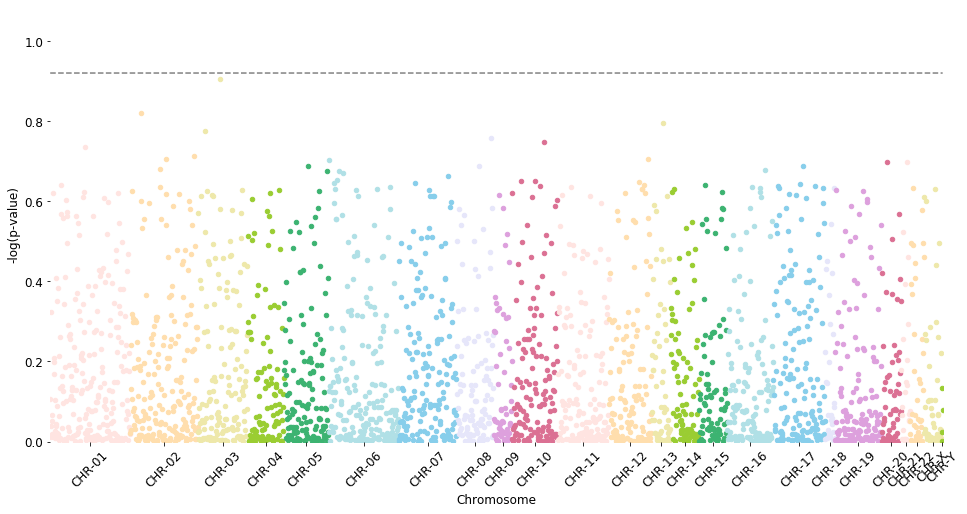

In [23]:
manhattan_plot(test_results, cutoff=0.12, palette='default', save=False) # , label_prefix='')

In [10]:
""" pvalues: diff bw the two phenotype labels (A vs B difference sig)
most p-values in the demo data are not near or below 0.05.
That means those probes / locations are not useful in separating the two phenotypes
"""
interesting_probes = test_results[test_results['PValue'] <= 0.13]
interesting_probes

,Coefficient,StandardError,PValue,95%CI_lower,95%CI_upper,FDR_QValue,minuslog10pvalue,chromosome
cg13537646,-3.634417,2.364558,0.124284,-8.268866,1.000031,0.999967,0.905585,03


## Testing linear regression

In [24]:
# usually you would pull this data from methylprep meta_data dataframe
# Create a linear regression dataset using strings that will be coerced to numbers (adult ages are estimates, not exact)
test_pheno_data2 = ["0","0","0","52","54","57"]

In [26]:
# Run a linear regression on the methylation data versus age of sample
test_results2 = diff_meth_pos(test_M_values_T.sample(60000, axis=1), #.iloc[:,:], # ALL probes. slow!
                              test_pheno_data2,
                              regression_method="linear")

In [27]:
interesting_probes = test_results2[test_results2['PValue'] <= 0.05]
print(len(interesting_probes))
interesting_probes.head()

12975


,Coefficient,StandardError,PValue,95%CI_lower,95%CI_upper,FDR_QValue
cg23165623,-0.089640,0.000837,1.342041e-09,-0.091790,-0.087490,0.000081
cg00088844,-0.067228,0.000762,3.536345e-09,-0.069186,-0.065270,0.000106
cg01093363,-0.063621,0.000880,9.600144e-09,-0.065883,-0.061358,0.000192
cg01721754,-0.073975,0.001235,2.454493e-08,-0.077150,-0.070801,0.000305
cg18768347,0.090029,0.001570,3.048514e-08,0.085994,0.094064,0.000305


Total probes to plot: 56286
CHR-01 5481 | CHR-02 4000 | CHR-03 2940 | CHR-04 2405 | CHR-05 2767 | CHR-06 4148 | CHR-07 3383 | CHR-08 2364 | CHR-09 1127 | CHR-10 2808 | CHR-11 3261 | CHR-12 2808 | CHR-13 1460 | CHR-14 1790 | CHR-15 1761 | CHR-16 2559 | CHR-17 3289 | CHR-18 709 | CHR-19 3043 | CHR-20 1236 | CHR-21 503 | CHR-22 1014 | CHR-X 1389 | CHR-Y 41
p-value line: 3.0


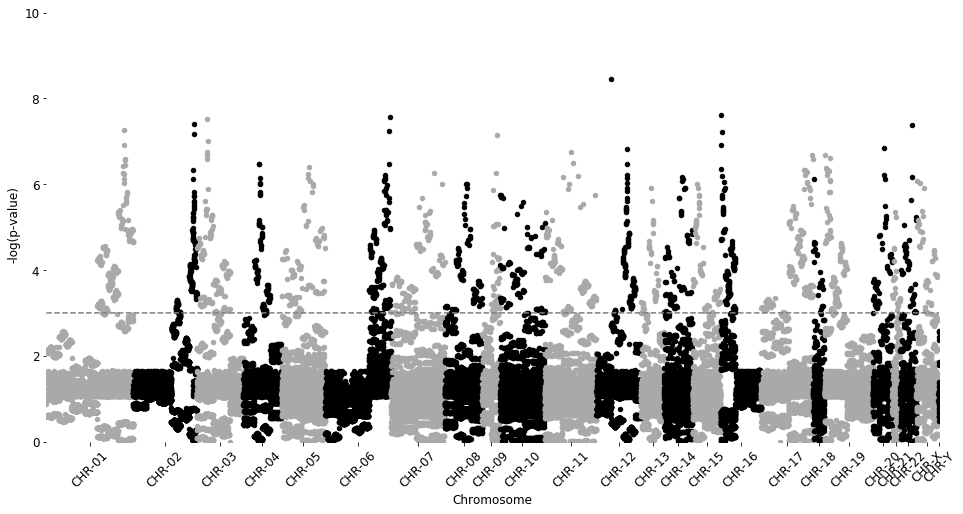

In [30]:
manhattan_plot(test_results2, cutoff=0.001, palette='Gray3', save=False)

## Testing Volcano plot visualizations

Excluded 8878 probes outside of the specified beta coefficient range: (-0.02, 0.02)


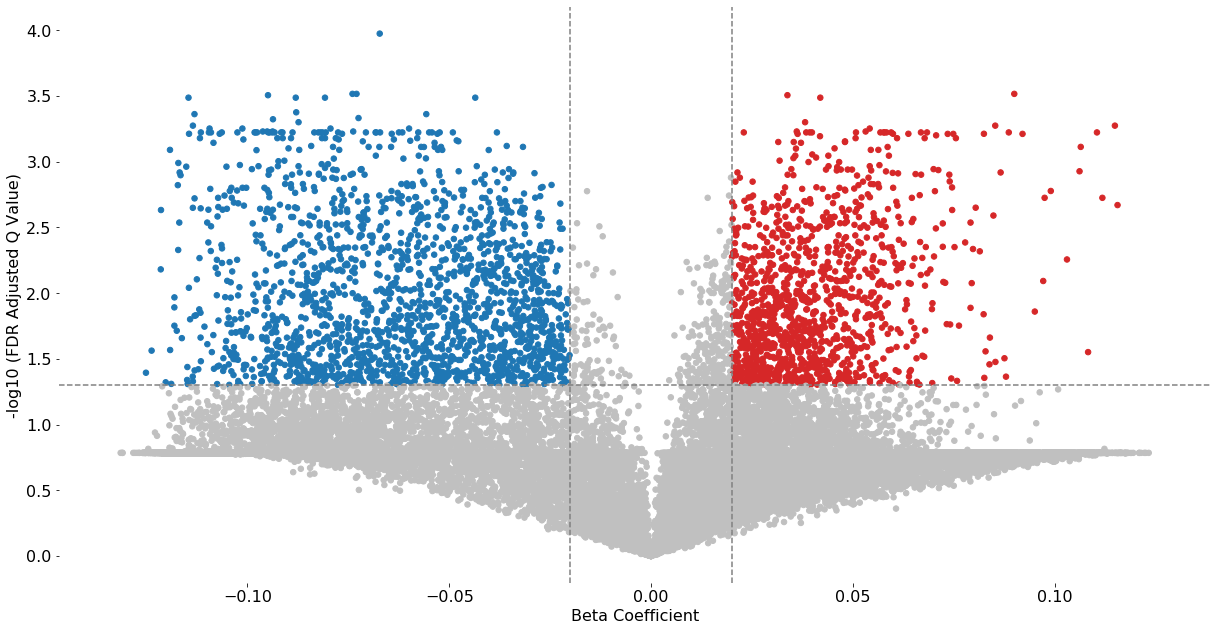

In [37]:
volcano_plot(test_results2, fontsize=16, cutoff=0.05, beta_coefficient_cutoff=(-0.02,0.02), save=False)